In [1]:
! pip install pandas


[notice] A new release of pip available: 22.1.2 -> 23.1.2
[notice] To update, run: C:\Users\a_mut\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


# GLobal Constants

In [2]:
DATASET_DIR = "..\dataset\IIIT-CFW1.0"
CARTOON_DATASET = "cartoonFaces"
REAL_FACES = "realFaces"
DATASET_FILE = "dataset.csv"

RANDOM_STATE = 1

# Load the Dataset

In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader
import os, sys

root_dir = os.path.abspath(os.path.join('..'))
if root_dir not in sys.path:
    sys.path.append(root_dir)
from src.dataset import RealCartoon

datasets = {
    phase: RealCartoon(
        csv_file=f"{DATASET_DIR}/{DATASET_FILE}",
        set_type=phase,
        root_dir='./',
        transforms=transforms.Compose([
            transforms.Resize((224,224)),
            transforms.RandomHorizontalFlip(p=0.25),
            transforms.RandomVerticalFlip(p=0.25),
            transforms.ColorJitter(brightness=(0.8,1), contrast=(0.8,1)),
            transforms.RandomGrayscale(p=0.1),
            transforms.RandomPerspective(),
            transforms.RandomRotation(degrees=(0, 60)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    )
    for phase in ['train', 'test', 'val']
}

dataloaders = {
    phase: DataLoader(
        datasets[phase], 
        batch_size=64,
        shuffle=True, 
        num_workers=8
        )
    for phase in ['train', 'test', 'val']
}

# Plot Sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


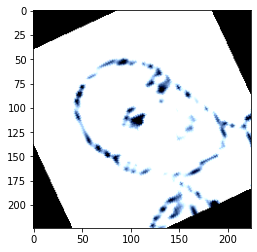

In [4]:
import random
import matplotlib.pyplot as plt

image_index = random.randint(0,len(datasets['test']))

plt.imshow(datasets['test'][image_index][0].permute(1, 2, 0)  )


# Load Pre-Trained Model

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models


import time
import os
import copy

In [6]:
# efficientnet_b7 = models.efficientnet_b7(progress=True, pretrained=True)
# efficientnet_b7([val_dataset[2][0], val_dataset[0][0]])

In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [8]:

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [12]:
resnet18 = models.resnet18(progress=True, pretrained=True)
num_filters = resnet18.fc.in_features
for param in resnet18.parameters():
    param.requires_grad = False
# resnet18.fc = nn.Linear(num_filters, 1)
# resnet18 = resnet18.to(device)

# criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(resnet18.fc.parameters(), lr=0.001)

# step_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# model_conv = train_model(resnet18, criterion, optimizer,
#                          step_lr_scheduler, num_epochs=25)

C:\Users\a_mut\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\a_mut\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.8_qbz5n2kfra8p0\LocalCache\local-packages\Python38\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [13]:
resnet18([datasets['train'][0][0]])

TypeError: conv2d() received an invalid combination of arguments - got (list, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list of [Tensor]!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!list of [Tensor]!, !Parameter!, !NoneType!, !tuple of (int, int)!, !tuple of (int, int)!, !tuple of (int, int)!, int)


In [17]:
datasets['train'][0][0].size()

torch.Size([3, 224, 224])